In [3]:
import logging
import os
from typing import Sequence

import fire
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

import torchsde

In [4]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

In [5]:
class StochasticLorenz(object):

    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out

In [7]:
class LatentSDE(nn.Module):
    sde_type = "ito"
    noise_type = "diagonal"

    def __init__(self, data_size, latent_size, context_size, hidden_size):
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=False, method="euler"):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1e-2, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1e-2, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1e-3, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs

In [22]:
def make_dataset(t0, t1, batch_size, noise_std, steps, train_dir, device):
    data_path = os.path.join(train_dir, 'lorenz_data.pth')
    if os.path.exists(data_path):
        data_dict = torch.load(data_path)
        xs, ts = data_dict['xs'], data_dict['ts']
        logging.warning(f'Loaded toy data at: {data_path}')
        if xs.shape[1] != batch_size:
            raise ValueError("Batch size has changed; please delete and regenerate the data.")
        if ts[0] != t0 or ts[-1] != t1:
            raise ValueError("Times interval [t0, t1] has changed; please delete and regenerate the data.")
    else:
        _y0 = torch.randn(batch_size, 3, device=device)
        ts = torch.linspace(t0, t1, steps=steps, device=device)
        xs = StochasticLorenz().sample(_y0, ts, noise_std, normalize=True)

        os.makedirs(os.path.dirname(data_path), exist_ok=True)
        torch.save({'xs': xs, 'ts': ts}, data_path)
        logging.warning(f'Stored toy data at: {data_path}')
    return xs, ts

In [12]:
def extractShorter(xs, t_vae, t1, ts, steps):
    threshold = t_vae / t1 * steps
    xs_vae = xs[0:int(threshold), :, :]
    ts_vae = ts[0:int(threshold)]
    return xs_vae, ts_vae

In [14]:
def vis(xs, ts, xs_full, ts_full, latent_sde, bm_vis, img_path, num_samples=10, long_num_samples = 2):
    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 4)
    ax00 = fig.add_subplot(gs[0, 0], projection='3d')
    ax01 = fig.add_subplot(gs[0, 1], projection='3d')
    ax02 = fig.add_subplot(gs[0, 2], projection='3d')
    ax03 = fig.add_subplot(gs[0, 3], projection='3d')

    # Left plot: data.
    z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('VAE Training Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1, z2, z3 = np.split(xs, indices_or_sections=3, axis=-1)

    [ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples from VAE Learned Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    ax01.set_zlim(zlim)

    z1_full, z2_full, z3_full = np.split(xs_full.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax02.plot(z1_full[:, i, 0], z2_full[:, i, 0], z3_full[:, i, 0]) for i in range(long_num_samples)]
    ax02.scatter(z1_full[0, :long_num_samples, 0], z2_full[0, :long_num_samples, 0], z3_full[0, :long_num_samples, 0], marker='x')
    ax02.set_yticklabels([])
    ax02.set_xticklabels([])
    ax02.set_zticklabels([])
    ax02.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax02.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax02.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax02.set_title('Full Training Data', fontsize=20)
    ax02.set_xlim(xlim)
    ax02.set_ylim(ylim)
    ax02.set_zlim(zlim)

    with torch.no_grad():
        context_full = latent_sde.encoder(torch.flip(xs_full, dims=(0,)))
        context_full = torch.flip(context_full, dims=(0,))
        latent_sde.contextualize((ts_full, context_full))

        qz0_mean, qz0_logstd = latent_sde.qz0_net(context_full[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)
        zs_full, log_ratio = torchsde.sdeint_adjoint(
            latent_sde, z0, ts_full, dt=1e-2, logqp=True, method="euler")
        _xs_full = latent_sde.projector(zs_full)
    
    z1_full_pred, z2_full_pred, z3_full_pred = np.split(_xs_full.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax03.plot(z1_full_pred[:, i, 0], z2_full_pred[:, i, 0], z3_full_pred[:, i, 0]) for i in range(long_num_samples)]
    ax03.scatter(z1_full_pred[0, :long_num_samples, 0], z2_full_pred[0, :long_num_samples, 0], z3_full_pred[0, :long_num_samples, 0], marker='x')
    ax03.set_yticklabels([])
    ax03.set_xticklabels([])
    ax03.set_zticklabels([])
    ax03.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax03.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax03.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax03.set_title('Full Training Data Predicted', fontsize=20)
    ax03.set_xlim(xlim)
    ax03.set_ylim(ylim)
    ax03.set_zlim(zlim)

    plt.savefig(img_path)
    plt.close()


In [26]:
batch_size=1024
latent_size=4
context_size=64
hidden_size=128
lr_init=1e-2
t0=0.
t1=10.
steps = 500
lr_gamma=0.997
kl_anneal_iters=1000
pause_every=50
noise_std=0.01
adjoint=False
train_dir='./lorenz_63_withMSE/'
method="euler"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
xs_full, ts_full= make_dataset(t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std, 
                      train_dir=train_dir, steps = steps, device=device)

In [31]:
xs_vae, ts_vae = extractShorter(xs_full, t_vae=2, t1=t1, ts=ts_full, steps=steps)

In [35]:
latent_sde = LatentSDE(
    data_size=3,
    latent_size=latent_size,
    context_size=context_size,
    hidden_size=hidden_size,
).to(device)

In [40]:
optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_gamma)

mse_loss_fn = torch.nn.MSELoss()  # MSE loss function
optimizer_mse = torch.optim.Adam(params=latent_sde.parameters(), lr=lr_init)  # Optimizer for MSE


kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=ts_vae[-1], size=(batch_size, latent_size,), device=device, 
        levy_area_approximation="space-time")

  0%|          | 3/5000 [01:42<47:28:33, 34.20s/it]


KeyboardInterrupt: 

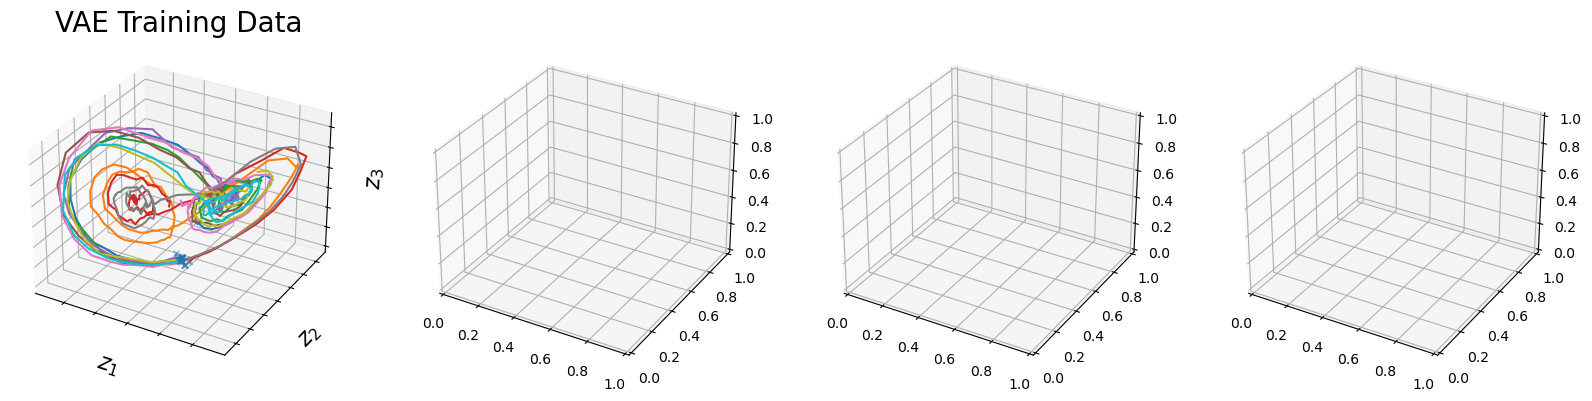

In [41]:
num_iters=5000

for global_step in tqdm.tqdm(range(1, num_iters + 1)):
    latent_sde.zero_grad()
    log_pxs, log_ratio = latent_sde(xs_vae, ts_vae, noise_std, adjoint, method)
    loss = -log_pxs + log_ratio * kl_scheduler.val
    loss.backward()
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()

    if global_step % 10 == 0:
        with torch.no_grad():
            context_full = latent_sde.encoder(torch.flip(xs_full, dims=(0,)))
            context_full = torch.flip(context_full, dims=(0,))
            latent_sde.contextualize((ts_full, context_full))

            qz0_mean, qz0_logstd = latent_sde.qz0_net(context_full[0]).chunk(chunks=2, dim=1)
            z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)
            zs_full, log_ratio = torchsde.sdeint_adjoint(
                latent_sde, z0, ts_full, dt=1e-2, logqp=True, method="euler")
            _xs_full = latent_sde.projector(zs_full)
            
            optimizer_mse.zero_grad()
            mse_loss = mse_loss_fn(_xs_full, xs_full)
            mse_loss.backward()
            optimizer_mse.step()

    if global_step <= 50 or global_step % pause_every == 0:
        lr_now = optimizer.param_groups[0]['lr']
        logging.warning(
            f'global_step: {global_step:06d}, lr: {lr_now:.5f}, '
            f'log_pxs: {log_pxs:.4f}, log_ratio: {log_ratio:.4f} loss: {loss:.4f}, kl_coeff: {kl_scheduler.val:.4f}'
        )
        img_path = os.path.join(train_dir, f'global_step_{global_step:06d}.pdf')
        vis(xs_vae, ts_vae, xs_full, ts_full, latent_sde, bm_vis, img_path)